# Validation - Solutions

In [9]:
%%sql --module california_housing
SELECT * FROM $california_housing

In [10]:
import datalab.bigquery as bq
from IPython import display
import math
from matplotlib import cm
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
from numpy import linspace
import pandas as pd
import sklearn.metrics as metrics
import tensorflow as tf

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

california_housing_dataframe = bq.Query(
    california_housing, california_housing=bq.Table('mlcc-playground:california_housing.train')
).to_dataframe()

california_housing_dataframe = california_housing_dataframe.reindex(
    np.random.permutation(california_housing_dataframe.index))

In [11]:
def preprocess_features(california_housing_dataframe):
  """Prepares input features from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the features to be used for the model, including
    synthetic features.
  """
  selected_features = california_housing_dataframe[
    ["latitude",
     "longitude",
     "housing_median_age",
     "total_rooms",
     "total_bedrooms",
     "population",
     "households",
     "median_income"]]
  processed_features = selected_features.copy()
  # Create a synthetic feature.
  processed_features["rooms_per_person"] = (
    california_housing_dataframe["total_rooms"] /
    california_housing_dataframe["population"])
  return processed_features

def preprocess_targets(california_housing_dataframe):
  """Prepares target features (i.e., labels) from California housing data set.

  Args:
    california_housing_dataframe: A Pandas DataFrame expected to contain data
      from the California housing data set.
  Returns:
    A DataFrame that contains the target feature.
  """
  output_targets = pd.DataFrame()
  # Scale the target to be in units of thousands of dollars.
  output_targets["median_house_value"] = (
    california_housing_dataframe["median_house_value"] / 1000.0)
  return output_targets

In [12]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))

### Solution to Examine the data - sanity check
Sanity checking data means checking it against some previous level of expectations.

For some values, like `median_house_value`, we can check to see if these values fall within reasonable ranges (keeping in mind this was 1990 data — not today!).

For other values, like `latitude` and `longitude`, we can do a quick check to see if these line up with expected values from a quick Google search.

But if you look closely, you might see some oddities. For example, `median_income` is on a scale from about 3 to 15. Not at all clear what this scale refers to — looks like maybe some log scale? It's not documented anywhere; all we can assume is that higher is more.

Also, the maximum median_house_value is capped at 500,001. This looks like an artificial cap of some kind.

Finally, our `rooms_per_person` feature is generally on a sane scale, with a 75<sup>th</sup> percentile value of about 2. But there are some very large values, like 18 or 55, which may show some amount of corruption in the data.

We'll use these features as given for now. But hopefully these kinds of examples can help to build a little intuition about how to sanity check data that comes to you from an unknown source.

### Solution to Examine the data - latitude and longitude
Looking at the tables of summary stats above, it's easy to wonder how anyone would do a useful sanity check. What's the right 75<sup>th</sup> percentile value for total_rooms per city block?

The key thing to notice is that for any given feature or column, the distribution of values between the train and validation splits should be roughly equal.

You'll recall that this is one of the three key points from the ML Fine Print: our data splits should all be drawn from the *same distribution*.

The fact that this is not the case is a real worry, and shows that we likely have a fault in the way that our train and validation split was created.

### Solution to Task 1
Take a look at how the data is randomized when it's read in.

If we didn't randomize the data properly before creating training and validation splits, then we'd be in trouble if the data was given to us in some sorted order.

### Solution to Task 2
This is just one possible setting; there may be other combinations of parameter settings that also give good results. Note that in general, this exercise isn't about finding the One Best setting, but rather about getting the experience of exploring parameter settings.

In [13]:
def train_model(
    learning_rate,
    steps,
    batch_size,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets):
  """Trains a linear regression model of one feature.
  
  In addition to training, this function also prints training progress information,
  as well as a plot of the training and validation loss over time.
  
  Args:
    learning_rate: A `float`, the learning rate.
    steps: A non-zero `int`, the total number of training steps. A training step
      consists of a forward and backward pass using a single batch.
    batch_size: A non-zero `int`, the batch size.
    training_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for training.
    training_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for training.
    validation_examples: A `DataFrame` containing one or more columns from
      `california_housing_dataframe` to use as input features for validation.
    validation_targets: A `DataFrame` containing exactly one column from
      `california_housing_dataframe` to use as target for validation.
      
  Returns:
    A `LinearRegressor` object trained on the training data.
  """

  periods = 10
  steps_per_period = steps / periods

  # Create a linear regressor object.
  feature_columns = tf.contrib.learn.infer_real_valued_columns_from_input(
      training_examples)
  linear_regressor = tf.contrib.learn.LinearRegressor(
      feature_columns=feature_columns,
      optimizer=tf.train.GradientDescentOptimizer(learning_rate=learning_rate),
      gradient_clip_norm=5.0
  )

  # Train the model, but do so inside a loop so that we can periodically assess
  # loss metrics.
  print "Training model..."
  print "RMSE (on training data):"
  training_rmse = []
  validation_rmse = []
  for period in range (0, periods):
    # Train the model, starting from the prior state.
    linear_regressor.fit(
        training_examples,
        training_targets,
        steps=steps_per_period,
        batch_size=batch_size
    )
    # Take a break and compute predictions.
    training_predictions = list(linear_regressor.predict(training_examples))
    validation_predictions = list(linear_regressor.predict(validation_examples))
    # Compute training and validation loss.
    training_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(training_predictions, training_targets))
    validation_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(validation_predictions, validation_targets))
    # Occasionally print the current loss.
    print "  period %02d : %0.2f" % (period, training_root_mean_squared_error)
    # Add the loss metrics from this period to our list.
    training_rmse.append(training_root_mean_squared_error)
    validation_rmse.append(validation_root_mean_squared_error)
  print "Model training finished."

  # Output a graph of loss metrics over periods.
  plt.ylabel("RMSE")
  plt.xlabel("Periods")
  plt.title("Root Mean Squared Error vs. Periods")
  plt.tight_layout()
  plt.plot(training_rmse, label="training")
  plt.plot(validation_rmse, label="validation")
  plt.legend()

  return linear_regressor

Training model...
RMSE (on training data):
  period 00 : 218.29
  period 01 : 200.65
  period 02 : 186.62
  period 03 : 176.14
  period 04 : 170.42
  period 05 : 168.26
  period 06 : 168.45
  period 07 : 170.14
  period 08 : 172.61
  period 09 : 175.10
Model training finished.


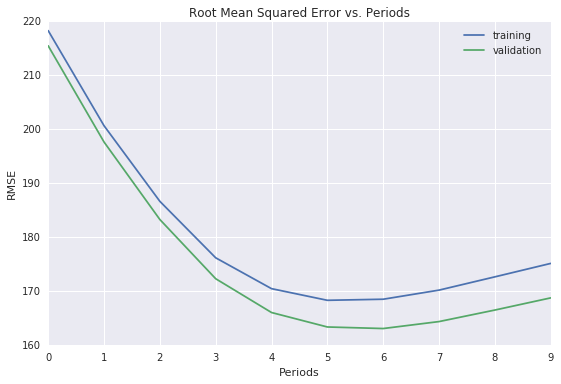

In [14]:
linear_regressor = train_model(
    learning_rate=0.00003,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets)

### Solution to Task 3
Similarly to what the loading code does, we just need to load the appropriate data file, preprocess it and use `predict` and `mean_squared_error`.

Note that we don't have to randomize the test data, since we will use all records.

In [8]:
california_housing_test_data = bq.Query(
    california_housing, california_housing=bq.Table('mlcc-playground:california_housing.test')
).to_dataframe()

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

test_predictions = list(linear_regressor.predict(test_examples))
root_mean_squared_error = math.sqrt(
    metrics.mean_squared_error(test_predictions, test_targets))

print "Final RMSE (on test data): %0.2f" % root_mean_squared_error

Final RMSE (on test data): 161.58
